In [ ]:
# This command install the Xelatex typesetting engine on your Debian-based machine
!chmod u+x dependencies.sh && sudo apt-get update && sudo bash dependencies.sh

Hit:1 http://security.debian.org/debian-security buster/updates InRelease
Hit:2 http://deb.debian.org/debian buster InRelease
Hit:3 http://deb.debian.org/debian buster-updates InRelease




git-lfs is already the newest version (2.7.1-1+deb10u1).
nano is already the newest version (3.2-3).
texlive-xetex is already the newest version (2018.20190227-2).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.


In [ ]:
import pickle
import pandas as pd
import tikzplotlib
import numpy as np
from operator import itemgetter
from tabulate import tabulate
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from pysurvival.models.simulations import SimulationModel
from pysurvival.models.multi_task import NeuralMultiTaskModel
from pysurvival.utils.metrics import concordance_index
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.display import integrated_brier_score
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel, RandomSurvivalForestModel
from pysurvival.models.non_parametric import KaplanMeierModel
from pysurvival.utils.display import display_non_parametric
from pandas_profiling import ProfileReport
from pysurvival.utils.display import correlation_matrix
%pylab inline

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

#plt.style.use('tableau-colorblind10')
#plt.style.use('grayscale')

dataset_flag = "cs" # can be 'ds' or 'cs' or 'p'
censoring_margin = 36 # can be '24' or '36'
featureset = "cb+b" # can be 'cb' or 'b' or 'cb+b'
num_runs = 0

# Reading the dataset
raw_dataset = pd.read_csv("dataset/{0}/user_features.csv".format(dataset_flag), sep="\t")
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head(3)

Populating the interactive namespace from numpy and matplotlib
The raw_dataset has the following shape: (113433, 19).


,UserId,CreationDate,CastDownVotes,CastUpVotes,ProfileViews,LastAccessDate,QuestionCount,AnswerCount,CommentCount,AvgQuestionViewCount,AvgQuestionFavouriteCount,AvgQuestionCommentCount,AvgQuestionScore,AvgAnswerScore,AvgAnswerCommentCount,AvgCommentScore,MonthsActive,MonthsSinceLastActivity,MonthsSinceJoined
0,74,2012-03-06 20:09:16,0,0,0,2012-03-06 20:09:16,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112
1,93,2012-03-06 22:11:12,0,0,0,2012-03-06 22:11:12,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112
2,109,2012-03-07 01:15:40,0,0,0,2012-03-07 01:15:40,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,112,112


In [ ]:
raw_dataset_tmp = raw_dataset.copy()
raw_dataset_tmp = raw_dataset_tmp[(raw_dataset_tmp['CastDownVotes'] > 0) | 
               (raw_dataset_tmp['CastUpVotes'] > 0) | 
               (raw_dataset_tmp['QuestionCount'] > 0) |
               (raw_dataset_tmp['AnswerCount'] > 0) |
               (raw_dataset_tmp['CommentCount'] > 0)]

raw_dataset_tmp.reset_index(inplace=True)
raw_dataset = raw_dataset_tmp

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}", textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

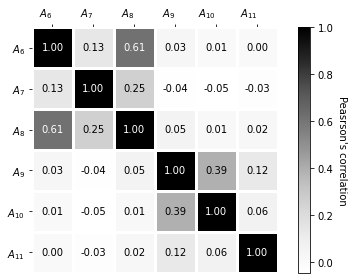

In [ ]:
# content-based attributes
features_content_based = ['AvgQuestionViewCount', 'AvgQuestionCommentCount',
                          'AvgQuestionScore', 'AvgAnswerScore',
                          'AvgAnswerCommentCount', 'AvgCommentScore']

raw_dataset_corr = raw_dataset[features_content_based].copy()
raw_dataset_corr.rename(columns={'AvgQuestionViewCount': 'A_6', 'AvgQuestionCommentCount': 'A_7',
                                 'AvgQuestionScore': 'A_8', 'AvgAnswerScore': 'A_9',
                                 'AvgAnswerCommentCount': 'A_10', 'AvgCommentScore': 'A_11'}, inplace=True)

fig, ax = plt.subplots()

attributes = ["$A_6$", "$A_7$", "$A_8$", "$A_9$", "$A_{10}$", "$A_{11}$"]

im, cbar = heatmap(raw_dataset_corr.corr(), attributes, attributes, ax=ax,
                   cmap="Greys", cbarlabel="Peasrson's correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

fig.savefig('figures/{0}/attribute_corr_content_based.pgf'.format(dataset_flag))

plt.show()

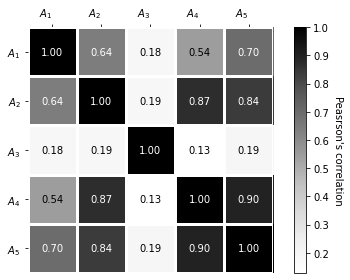

In [ ]:
# behavioural attributes
features_behvavioural = ['CastDownVotes', 'CastUpVotes', 'QuestionCount',
                         'AnswerCount', 'CommentCount']

raw_dataset_corr = raw_dataset[features_behvavioural].copy()
raw_dataset_corr.rename(columns={'CastDownVotes': 'A_1', 'CastUpVotes': 'A_2',
                                 'QuestionCount': 'A_3', 'AnswerCount': 'A_4',
                                 'CommentCount': 'A_5'}, inplace=True)

fig, ax = plt.subplots()

attributes = ["$A_1$", "$A_2$", "$A_3$", "$A_4$", "$A_5$"]

im, cbar = heatmap(raw_dataset_corr.corr(), attributes, attributes, ax=ax,
                   cmap="Greys", cbarlabel="Peasrson's correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()

fig.savefig('figures/{0}/attribute_corr_behavioural.pgf'.format(dataset_flag))

plt.show()

In [ ]:
def f(x):
    if x > censoring_margin:
        return 1
    else:
        return 0
    
raw_dataset['disengaged'] = raw_dataset['MonthsSinceLastActivity'].apply(f)

In [ ]:
raw_dataset.head()

,index,UserId,CreationDate,CastDownVotes,CastUpVotes,ProfileViews,LastAccessDate,QuestionCount,AnswerCount,CommentCount,...,AvgQuestionFavouriteCount,AvgQuestionCommentCount,AvgQuestionScore,AvgAnswerScore,AvgAnswerCommentCount,AvgCommentScore,MonthsActive,MonthsSinceLastActivity,MonthsSinceJoined,disengaged
0,4,143,2012-03-07 16:21:44,0,2,1,2012-03-07 16:21:44,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,111,111,1
1,5,177,2012-03-10 03:24:40,0,2,1,2012-03-10 03:24:40,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,111,111,1
2,6,166,2012-03-08 21:54:51,0,3,0,2012-03-11 06:42:16,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,111,111,1
3,11,9,2012-03-06 18:47:32,0,3,3,2012-03-20 19:57:27,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,111,112,1
4,12,38,2012-03-06 19:07:54,0,8,0,2012-03-20 20:03:54,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,111,112,1


In [ ]:
if featureset == 'cb':
    features = features_content_based 
elif featureset == 'b':
    features = features_behvavioural
elif featureset == 'cb+b':
    features = features_behvavioural + features_content_based
else:
    # raises an error
    features = None

time_column = "MonthsActive"
event_column = "disengaged"

raw_dataset_cut = raw_dataset.copy()[features + [time_column, event_column]]

In [ ]:
# Reading the dataset
N = raw_dataset_cut.shape[0]
dataset = raw_dataset_cut


def fit1(model, X_train, T_train, E_train, seed):
        return model.fit(X_train, T_train, E_train,
                         max_features="sqrt", max_depth=5, min_node_size=30,
                         num_threads=-1, weights=None, sample_size_pct=0.63, 
                         importance_mode='permutation', seed=seed, 
                         save_memory=False)

models_data = dict()
    
# runs
for i in range(0, num_runs):
    
    seed = None
    
    # Building training and testing sets #
    index_train, index_test = train_test_split(range(N), test_size = 0.01, random_state=seed)
    data_train = dataset.loc[index_train].reset_index(drop=True)
    data_test = dataset.loc[index_test].reset_index(drop=True)

    # Creating the X, T and E input
    X_test = data_test[features]
    T_test = data_test[time_column]
    E_test = data_test[event_column]

    model = RandomSurvivalForestModel(num_trees=5)

    average_c_index = 0.0
    n_fold = 5

    kf = KFold(n_splits=n_fold)
    for fold, te in enumerate(kf.split(data_train)):
        trainining, evaluation = te

        data_train_kf =data_train.loc[trainining].reset_index(drop=True)
        data_eval_kf = data_train.loc[evaluation].reset_index(drop=True)

        X_train, X_evaluation = data_train_kf[features], data_eval_kf[features]
        T_train, T_evaluation = data_train_kf[time_column], data_eval_kf[time_column]
        E_train, E_evaluation = data_train_kf[event_column], data_eval_kf[event_column]

        fit1(model, X_train, T_train, E_train, seed)
        
        c_index = concordance_index(model, X_evaluation, T_evaluation, E_evaluation)
        print('Fold #{fold} C-index: {:.2f}'.format(c_index, fold=fold))
        
        models_data[(i, fold)] = (model.variable_importance, c_index)

        average_c_index += c_index

    print('Run {run}, Average C-index: {ci:.2f}'.format(run=i, ci=average_c_index/n_fold))

In [ ]:
with open("results/{0}/runs_info_{1}_{2}.none.bin".format(dataset_flag, str(censoring_margin), featureset),'wb') as runs_info:
    pickle.dump(models_data, runs_info)

In [ ]:
dataset_flag = "cs"
censoring_margin = 24
featureset = "cb+b"
print("results/{0}/runs_info_{1}_{2}.bin".format(dataset_flag,
                                                 str(censoring_margin), featureset))

results/cs/runs_info_24_cb+b.bin


In [ ]:
with open("results/{0}/runs_info_{1}_{2}.bin".format(dataset_flag, 
                                                    str(censoring_margin), featureset),'rb') as runs_info:
    models_data_loaded = pickle.load(runs_info)

#print(models_data_loaded)

In [ ]:
c_index = []
attribute_importance = dict()
for i, pair in enumerate(models_data_loaded.items()):
    _, v = pair
    c_index.append(v[1])
    
    for k, v2 in v[0].items():
        if k in attribute_importance:
            attribute_importance[k].append(v2)
        else:
            attribute_importance[k] = [v2]

print('Average C-index: {ci:.2f}'.format(ci=np.mean(c_index)))
round(np.std(c_index), 2)

Average C-index: 0.69


0.01

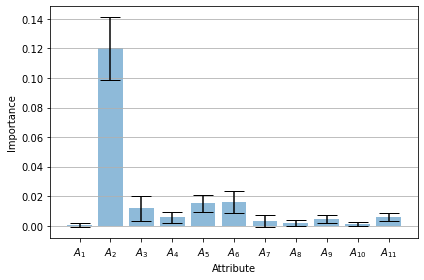

In [ ]:
df = pd.DataFrame(attribute_importance)

df2 = df.copy()

df2.rename(columns={'CastDownVotes': '$A_1$', 'CastUpVotes': '$A_2$',
                    'QuestionCount': '$A_3$', 'AnswerCount': '$A_4$',
                    'CommentCount': '$A_5$', 
                    
                    'AvgQuestionViewCount': '$A_6$', 'AvgQuestionCommentCount': '$A_7$', 
                    "AvgQuestionScore": '$A_8$', 'AvgAnswerScore': '$A_9$', 
                    'AvgAnswerCommentCount': '$A_{10}$', 'AvgCommentScore': '$A_{11}$', 
                    }, inplace=True)

df2 = df2.reindex(sorted(df2.columns), axis=1)

means = []
errors = []

for c in df2.columns:
    means.append(df2[c].median())
    errors.append(df2[c].std())

# Create lists for the plot
materials = list(df2.columns)
x_pos = np.arange(len(materials))
CTEs = means
error = errors

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', 
       alpha=0.5, ecolor='black', capsize=10)

ax.set_ylabel('Importance')
ax.set_xlabel('Attribute')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('figures/{0}/bar_plot_with_error_bars.pgf'.format(dataset_flag))
plt.show()

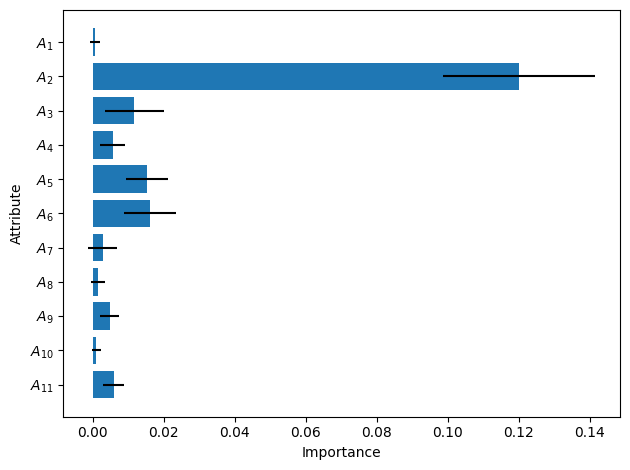

In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = list(df2.columns)
y_pos = np.arange(len(people))
performance = means
error = errors

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_ylabel('Attribute')
ax.set_title('')
ax.yaxis.grid(False)

# Save the figure and show
plt.tight_layout()
plt.savefig('figures/{0}/bar_plot_with_error_bars_{1}_{2}.pgf'.format(dataset_flag,
                                                 str(censoring_margin), featureset))
plt.show()

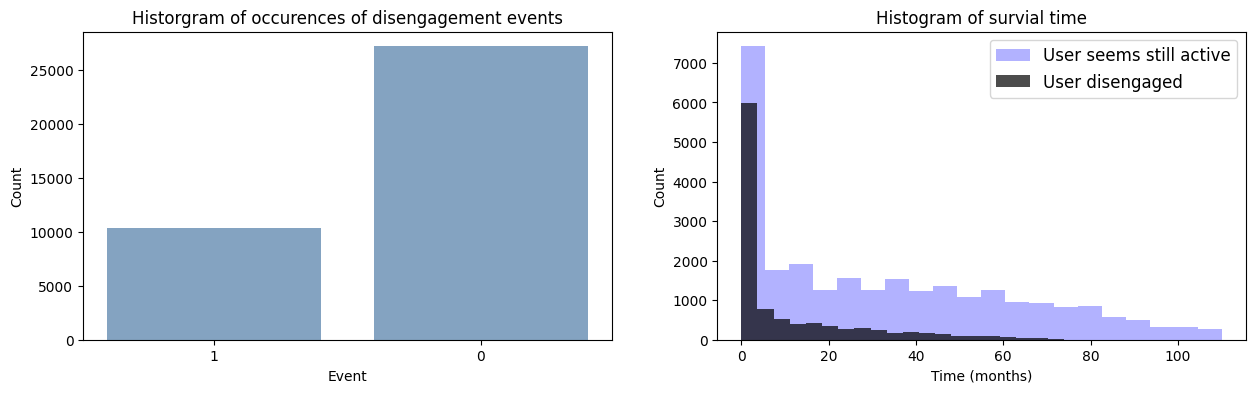

In [ ]:
from collections import Counter

# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(dataset['disengaged'])
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts, color=(0.2, 0.4, 0.6, 0.6))
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Historgram of occurences of disengagement events', fontsize=12)
ax1.set_xlabel("Event")
ax1.set_ylabel("Count")

# Showing the histogram of the survival times for the censoring
time_0 = dataset.loc[dataset['disengaged'] == 0, 'MonthsActive']
ax2.hist(time_0, bins=20, alpha=0.3, color='blue', label = 'User seems still active')

# Showing the histogram of the survival times for the events
time_1 = dataset.loc[dataset['disengaged'] == 1, 'MonthsActive']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'User disengaged')
ax2.set_title('Histogram of survial time', fontsize=12)
ax2.set_xlabel("Time (months)")
ax2.set_ylabel("Count")

# Displaying everything side-by-side
plt.legend(fontsize=12)
plt.savefig('figures/{0}/observation_period_not_last{1}.pgf'.format(dataset_flag, str(censoring_margin)))

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5b875ec7-933b-4a3a-92bc-cefd5e08f9f6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>